# Redlining in Fort Collins, Colorado



## A Troubled Past



## Import Necessary Packages

In [178]:
import os # Interoperable file paths
import pathlib # Find the home folder
import geopandas as gpd # Work with vector data
import hvplot
import pandas as pd
import hvplot.pandas # Interactive plots of vector data
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
from glob import glob # Find files by pattern
import numpy as np # Unpack bit-wise Fmask
import matplotlib.pyplot as plt # Make subplots
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
import earthaccess # Access NASA data from the cloud
from rioxarray.merge import merge_arrays # Merge rasters
import regionmask # Convert shapefile to mask
from xrspatial import zonal_stats # Calculate zonal statistics
import xarray as xr # Adjust images
import cartopy.crs as ccrs # CRSs
import regionmask # Convert shapefile to mask
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score

In [179]:
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'fortcollinsrl'
)
os.makedirs(data_dir, exist_ok=True)

## STEP 2: Site map

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Define your study area</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Copy the <strong>geopackage</strong> URL for the <a
href="https://dsl.richmond.edu/panorama/redlining/data">University of
Richmond</a></li>
<li>Load the <em>vector</em> data into Python, making sure to cache the
download so you don’t have to run it multiple times.</li>
<li>Create a quick plot to check the data</li>
</ol></div></div>

<Axes: >

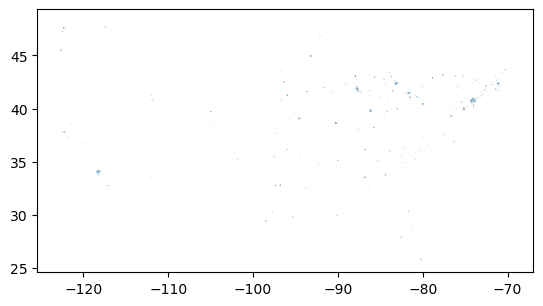

In [180]:
# Define info for redlining download
fortcollinsrl_url = (
    "https://dsl.richmond.edu"
    "/panorama/redlining/static/"
    "mappinginequality.gpkg"
)
# Set up a path to save the data on your machine
fortcollinsrl_dir = os.path.join(data_dir, 'fortcollinsrl')

# Make the redlining directory
os.makedirs(fortcollinsrl_dir, exist_ok=True)

# Join regions shapefile path
fortcollinsrl_path = os.path.join(fortcollinsrl_dir, 'fortcollinsrl.gpkg')

# Only download once
if not os.path.exists(fortcollinsrl_path):
    # Read the GeoPackage file from the URL
    fortcollinsrl_gdf = gpd.read_file(fortcollinsrl_url)
    # Save the data as a GeoPackage to the local path
    fortcollinsrl_gdf.to_file(fortcollinsrl_path, driver='GPKG')

# Load from file
fortcollinsrl_gdf = gpd.read_file(fortcollinsrl_path)

#Check the data
fortcollinsrl_gdf.plot()

In [181]:
fortcollinsrl_gdf.head(5)

,area_id,city,state,city_survey,category,grade,label,residential,commercial,industrial,fill,geometry
0,244,Birmingham,AL,True,Best,A,A1,True,False,False,#76a865,"MULTIPOLYGON (((-86.75678 33.49754, -86.75653 ..."
1,193,Birmingham,AL,True,Best,A,A2,True,False,False,#76a865,"MULTIPOLYGON (((-86.75867 33.50933, -86.76134 ..."
2,206,Birmingham,AL,True,Best,A,A3,True,False,False,#76a865,"MULTIPOLYGON (((-86.75678 33.49754, -86.75692 ..."
3,203,Birmingham,AL,True,Still Desirable,B,B1,True,False,False,#7cb5bd,"MULTIPOLYGON (((-86.80111 33.48071, -86.80505 ..."
4,189,Birmingham,AL,True,Still Desirable,B,B10,True,False,False,#7cb5bd,"MULTIPOLYGON (((-86.74923 33.53333, -86.74971 ..."


In [182]:
# # Create an interactive site map

fort_collins_redlining_gdf = fortcollinsrl_gdf[fortcollinsrl_gdf.city=='Fort Collins'] 

fort_collins_redlining_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='City of Fort Collins, CO',
    fill_color=None, line_color='red', line_width=3,
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [183]:

# Print the filtered GeoDataFrame to check if it's empty
print(fort_collins_redlining_gdf)


      area_id          city state  city_survey       category grade  \
1159    10382  Fort Collins    CO        False   Fourth Grade         
1160    10383  Fort Collins    CO        False    First Grade         
1161    10384  Fort Collins    CO        False   Second Grade         
1162    10385  Fort Collins    CO        False    Third Grade         
1163    10386  Fort Collins    CO        False  Fire District         

              label  residential  commercial  industrial     fill  \
1159   Fourth Grade         True       False       False  #561f18   
1160    First Grade         True       False       False  #2d3352   
1161   Second Grade         True       False       False  #364f3a   
1162    Third Grade         True       False       False  #afa53d   
1163  Fire District        False       False       False  #cbb5a2   

                                               geometry  
1159  MULTIPOLYGON (((-105.07481 40.59251, -105.0765...  
1160  MULTIPOLYGON (((-105.0756 40.56528, 

# STEP 3: Get the NDVI Data

In [184]:
earthaccess.login(strategy="interactive", persist=True)

In [185]:
fort_collins_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(fort_collins_redlining_gdf.total_bounds),
    temporal=("2024-07-29"),
    count=1
)
fort_collins_results

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -106.18162029, 'Latitude': 40.55670691}, {'Longitude': -104.88470844, 'Latitude': 40.56269239}, {'Longitude': -104.88296837, 'Latitude': 41.55178512}, {'Longitude': -106.1994491, 'Latitude': 41.54558877}, {'Longitude': -106.18162029, 'Latitude': 40.55670691}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-07-29T17:42:42.117Z', 'EndingDateTime': '2024-07-29T17:43:06.008Z'}}
 Size(MB): 182.66491508483887
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.B09.tif', 'https://da

In [186]:
# Open Data Connection
fort_collins_files = earthaccess.open(fort_collins_results)

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

In [187]:
fort_collins_files

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.B07.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.B09.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.B03.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.Fmask.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TDF.2024211T174242.v2.0/HLS.L30.T13TDF.2024211T174242.v2.0.SAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.ear

## Image Processing

In [188]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Connect to the raster image
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # Get the total boundary
    bounds = (
      bounds_gdf
      .to_crs(da.rio.crs)
      .total_bounds
)

  # Crop
    cropped_da = da.rio.clip_box(*bounds)

    return cropped_da

process_image(fort_collins_files[8], fort_collins_redlining_gdf)

<xarray.DataArray (y: 130, x: 127)> Size: 66kB
[16510 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 1kB 4.91e+05 4.91e+05 ... 4.947e+05 4.947e+05
  * y            (y) float64 1kB 4.494e+06 4.494e+06 ... 4.491e+06 4.491e+06
    spatial_ref  int64 8B 0
Attributes: (12/33)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            PRELIMINARY; PRELIMINARY
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       399960
    ULY:                       4600020
    USGS_SOFTWARE:             LPGS_16.4.0
    AREA_OR_POINT:             Area

/var/folders/j7/815c6qns6g39vvr0gw7cftfm0000gn/T/ipykernel_16820/2208555030.py:30: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


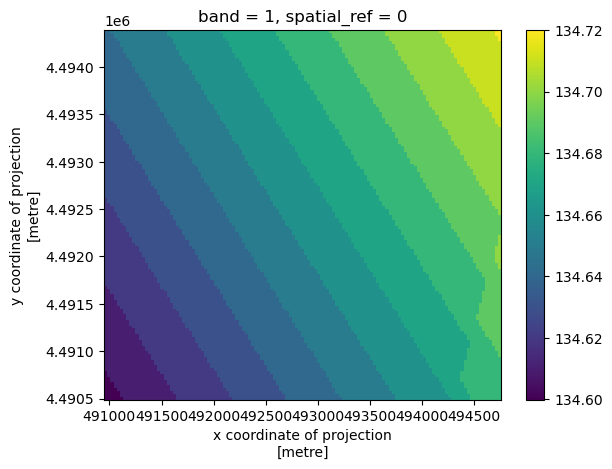

In [197]:
def process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
   
     """
    #open fmask file
    fmask_da = process_image (cloud_uri, bounds_gdf)

    #unlock the cloud mask bits
    cloud_bits = (
      np.unpackbits(
        (
            # Get the cloud mask as an array...
            fmask_da.values
            # ... of 8-bit integers
            .astype('uint8')
            # With an extra axis to unpack the bits into
            [:, :, np.newaxis]
        ), 
        # List the least significat bit first to match the user guide
        bitorder='little',
        # Expand the array in a new dimension
        axis=-1)
    )

    cloud_mask = np.sum(
        # Select bits
        cloud_bits[:,:,bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    # Check if any of bits are true
    ) == 0
    return cloud_mask

blue_da = process_image(fort_collins_files[4], fort_collins_redlining_gdf)
fort_collins_cloud_mask = process_cloud_mask(
    fort_collins_files[1],
    fort_collins_redlining_gdf,
   [1, 2, 3, 5])
blue_da.where(fort_collins_cloud_mask).plot()

In [190]:
# Compile a regular expression to search for metadata
uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\.(?P<band_id>.+)\.tif"
)

# Find all the metadata in the file name
uri_groups = [
   uri_re.search(fort_collins_files.full_name).groupdict()
   for fort_collins_files in fort_collins_files]

# Create a DataFrame with the metadata
raster_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
raster_df['file'] = fort_collins_files

# Check the results
raster_df

,tile_id,date,band_id,file
0,T13TDF,2024211,B07,"<File-like object HTTPFileSystem, https://data..."
1,T13TDF,2024211,B09,"<File-like object HTTPFileSystem, https://data..."
2,T13TDF,2024211,B03,"<File-like object HTTPFileSystem, https://data..."
3,T13TDF,2024211,Fmask,"<File-like object HTTPFileSystem, https://data..."
4,T13TDF,2024211,SAA,"<File-like object HTTPFileSystem, https://data..."
5,T13TDF,2024211,B11,"<File-like object HTTPFileSystem, https://data..."
6,T13TDF,2024211,VAA,"<File-like object HTTPFileSystem, https://data..."
7,T13TDF,2024211,VZA,"<File-like object HTTPFileSystem, https://data..."
8,T13TDF,2024211,B04,"<File-like object HTTPFileSystem, https://data..."
9,T13TDF,2024211,B02,"<File-like object HTTPFileSystem, https://data..."


## Process Data

In [198]:
# Labels for each band to process
bands = {
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    'B05': 'nir'
}
# Initialize structure for saving images
fort_collins_das = {band_name: [] for band_name in bands.values()}
for tile_id, tile_df in raster_df.groupby('tile_id'):
    #Load the cloud mask
    fmask_file = tile_df[tile_df.band_id=='Fmask'].file.values[0]
    cloud_mask = process_cloud_mask(
        fmask_file, 
        fort_collins_redlining_gdf,
         [1, 2, 3, 5])

    for band_id, row in tile_df.groupby('band_id'):
        if band_id in bands:
            band_name = bands[band_id]
            # Process band
            band_da = process_image(
                row.file.values[0],
                fort_collins_redlining_gdf)

             # Mask band
            band_masked_da = band_da.where(cloud_mask)

            # Store the resulting DataArray for later
            fort_collins_das[band_name].append(band_masked_da)
        
fort_collins_das

/var/folders/j7/815c6qns6g39vvr0gw7cftfm0000gn/T/ipykernel_16820/2208555030.py:30: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


{'red': [<xarray.DataArray (y: 130, x: 127)> Size: 66kB
  array([[0.0468    , 0.0426    , 0.0527    , ..., 0.1201    , 0.08679999,
          0.0551    ],
         [0.0995    , 0.0773    , 0.0661    , ..., 0.1026    , 0.0849    ,
          0.0889    ],
         [0.1102    , 0.1111    , 0.11059999, ..., 0.0484    , 0.065     ,
          0.0704    ],
         ...,
         [0.0403    , 0.0312    , 0.033     , ..., 0.0484    , 0.0619    ,
          0.067     ],
         [0.0511    , 0.049     , 0.0533    , ..., 0.0355    , 0.0434    ,
          0.049     ],
         [0.0541    , 0.0567    , 0.0596    , ..., 0.0415    , 0.0373    ,
          0.0326    ]], dtype=float32)
  Coordinates:
      band         int64 8B 1
    * x            (x) float64 1kB 4.91e+05 4.91e+05 ... 4.947e+05 4.947e+05
    * y            (y) float64 1kB 4.494e+06 4.494e+06 ... 4.491e+06 4.491e+06
      spatial_ref  int64 8B 0
  Attributes: (12/33)
      ACCODE:                    Lasrc; Lasrc
      arop_ave_xshift(meter

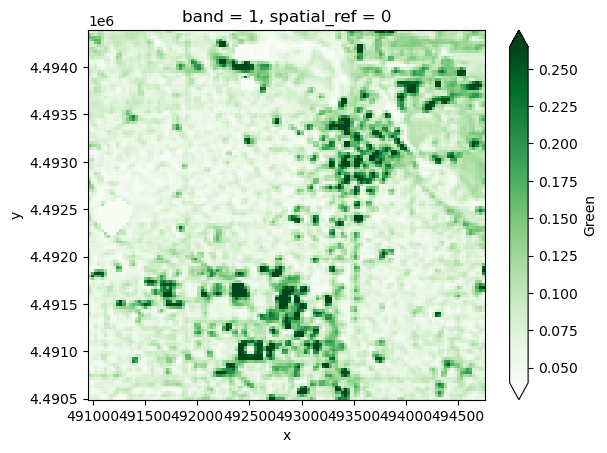

In [192]:
# Merge all tiles
fort_collins_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in fort_collins_das.items()}

# Plot a merged raster band
fort_collins_merged_das['green'].plot(cmap='Greens', robust=True)

In [199]:
# Calculate NDVI

fort_collins_ndvi = (
     (fort_collins_merged_das['nir'].values - fort_collins_merged_das['red'].values)
    / (fort_collins_merged_das['nir'].values + fort_collins_merged_das['red'].values)
)

coords= {
    'latitude': fort_collins_merged_das['red'].coords['y'].values,
    'longitude': fort_collins_merged_das['red'].coords['x'].values  
}
fort_collins_ndvi_da = xr.DataArray(fort_collins_ndvi, coords)

fort_collins_ndvi_da

/var/folders/j7/815c6qns6g39vvr0gw7cftfm0000gn/T/ipykernel_16820/3868386043.py:4: RuntimeWarning: invalid value encountered in divide
  (fort_collins_merged_das['nir'].values - fort_collins_merged_das['red'].values)


<xarray.DataArray (latitude: 130, longitude: 127)> Size: 66kB
array([[0.8096788 , 0.8204047 , 0.72651786, ..., 0.31371427, 0.44323283,
        0.6335218 ],
       [0.49747473, 0.59154564, 0.6189103 , ..., 0.4242424 , 0.38942826,
        0.39172086],
       [0.3865851 , 0.32727826, 0.34478673, ..., 0.713355  , 0.50645405,
        0.593768  ],
       ...,
       [0.7386511 , 0.80940753, 0.8087511 , ..., 0.7415221 , 0.64074296,
        0.55643827],
       [0.67688906, 0.6988322 , 0.6640404 , ..., 0.82160807, 0.7654054 ,
        0.7007634 ],
       [0.59791905, 0.5507132 , 0.52679634, ..., 0.8004807 , 0.7995163 ,
        0.8258081 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 1kB 4.494e+06 4.494e+06 ... 4.491e+06
  * longitude  (longitude) float64 1kB 4.91e+05 4.91e+05 ... 4.947e+05 4.947e+05

## Calculate Zonal Statistics

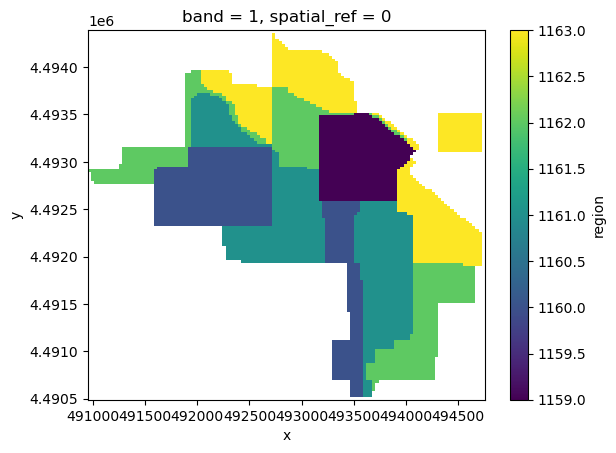

In [200]:
# Obtain mask for zones
fort_collins_redlining_mask = regionmask.mask_geopandas(
    fort_collins_redlining_gdf.to_crs(fort_collins_merged_das['red'].rio.crs), 
    fort_collins_merged_das['red'].x, # meters
    fort_collins_merged_das['red'].y, # meters 
    # The regions do not overlap bc no lat/long coords
    overlap=False,
    # We're not using geographic coordinates
    wrap_lon=False
)

fort_collins_redlining_mask.plot()

In [195]:
# Calculate NDVI stats for each redlining zone
fort_collins_ndvi_stats = zonal_stats(zones= fort_collins_redlining_mask, values= fort_collins_ndvi_da)

print(fort_collins_ndvi_stats)

     zone      mean       max       min          sum       std       var  \
0  1159.0  0.415854  1.214226 -0.009311   318.544281  0.166203  0.027623   
1  1160.0  0.621249  0.939011  0.029231   920.691406  0.137371  0.018871   
2  1161.0  0.629652  0.934990  0.142857  1207.043701  0.112230  0.012596   
3  1162.0  0.641187  0.946755  0.197562   925.232544  0.110335  0.012174   
4  1163.0  0.604086  0.915612  0.109867   891.630981  0.123574  0.015271   

    count  
0   766.0  
1  1482.0  
2  1917.0  
3  1443.0  
4  1476.0  


In [204]:
# Merge the NDVI stats with redlining geometry into one `GeoDataFrame`
fort_collins_ndvi_gdf = fortcollins_redlining_gdf.merge(
    fort_collins_ndvi_stats.set_index('zone'),
    left_index=True, right_index=True)

# Change the Grade column to empty and the label column to grade
# Rename multiple columns
fort_collins_ndvi_gdf = fort_collins_ndvi_gdf.rename(columns={'grade': 'empty', 'label': 'grade'})


# Change grade to ordered Categorical for plotting
fort_collins_ndvi_gdf.grade = pd.Categorical(
    fort_collins_ndvi_gdf.grade,
    ordered=True,
    #categories=['A', 'B', 'C', 'D']
)

# Drop rows with NA grades
fort_collins_ndvi_gdf = fort_collins_ndvi_gdf.dropna()


In [205]:
fort_collins_ndvi_gdf


,area_id,city,state,city_survey,category,empty,grade,residential,commercial,industrial,fill,geometry,mean,max,min,sum,std,var,count
1159.0,10382,Fort Collins,CO,False,Fourth Grade,,Fourth Grade,True,False,False,#561f18,"MULTIPOLYGON (((-105.07481 40.59251, -105.0765...",0.415854,1.214226,-0.009311,318.544281,0.166203,0.027623,766.0
1160.0,10383,Fort Collins,CO,False,First Grade,,First Grade,True,False,False,#2d3352,"MULTIPOLYGON (((-105.0756 40.56528, -105.07583...",0.621249,0.939011,0.029231,920.691406,0.137371,0.018871,1482.0
1161.0,10384,Fort Collins,CO,False,Second Grade,,Second Grade,True,False,False,#364f3a,"MULTIPOLYGON (((-105.07193 40.58418, -105.0758...",0.629652,0.934990,0.142857,1207.043701,0.112230,0.012596,1917.0
1162.0,10385,Fort Collins,CO,False,Third Grade,,Third Grade,True,False,False,#afa53d,"MULTIPOLYGON (((-105.0746 40.56591, -105.07395...",0.641187,0.946755,0.197562,925.232544,0.110335,0.012174,1443.0
1163.0,10386,Fort Collins,CO,False,Fire District,,Fire District,False,False,False,#cbb5a2,"MULTIPOLYGON (((-105.06299 40.57786, -105.0622...",0.604086,0.915612,0.109867,891.630981,0.123574,0.015271,1476.0


In [145]:
# Plot NDVI and redlining grade in linked subplots

(
    fort_collins_ndvi_gdf.hvplot(
        title='NDVI',
        c='mean',
        geo=True,
        cmap='Greens')
    +
    fort_collins_ndvi_gdf.hvplot(
        title='Redlining Grade',
        c='grade',
        geo=True,
        cmap='Blues')
)

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

In [206]:
print(fort_collins_ndvi_gdf['mean'].dtype)


float64


In [208]:
# # Convert the grade column into the correct type (it is currently an object)
fort_collins_ndvi_gdf['grade'] = fort_collins_ndvi_gdf['grade'].astype('category')


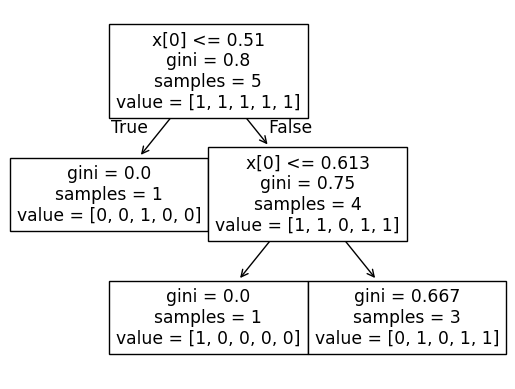

In [209]:
#Modeling
# Convert categories to numbers
fort_collins_ndvi_gdf['grade'] = fort_collins_ndvi_gdf.grade.cat.codes

# Fit model
tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
    fort_collins_ndvi_gdf[['mean']],
    fort_collins_ndvi_gdf.grade
) #optimal depth from exercise done in class 

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [211]:
fort_collins_ndvi_gdf['predictions'] = (
    tree_classifier.predict(fort_collins_ndvi_gdf[['mean']])
)
fort_collins_ndvi_gdf['error'] = (
    fort_collins_ndvi_gdf['predictions']
    - fort_collins_ndvi_gdf['grade']
)

fort_collins_ndvi_gdf.hvplot(c='error', geo=True)

:Polygons   [Longitude,Latitude]   (error)